In [1]:
import os
import numpy as np
import pandas as pd
import uproot as ur

import sys
sys.path.append('../')
from jupyter_utils import *

from matplotlib import pyplot as plt
from IPython.display import Image
pd.set_option('display.max_columns', None) # to see all columns of df.head()
pd.set_option('display.max_rows', None)

from matplotlib.patches import PathPatch
from matplotlib.path import Path

# Lauren's colors
L_colors = ['red', 'darkorange', 'limegreen', 'green', 'deepskyblue', 'blue', 'black']
L_linestyles = ['solid', 'dashed']
L_markers = ['s', '^', 'v', 'd', 'P']

In [2]:
# closure test? i.e. there is truth pythia data somewhere to compare to
closure = True

# define binnings
n_bins = [20, 20, 6] # WARNING RooUnfold seg faults if too many bins used
binning = [np.logspace(-5,0,n_bins[0]+1), \
            np.logspace(-2.09,0,n_bins[1]+1), \
            np.array([5, 20, 40, 60, 80, 100, 150]).astype(float) ]
print(binning)
bincenters = [ get_log_bincenters(binning[0]), get_log_bincenters(binning[1]), get_lin_bincenters(binning[2]) ]
binwidths = [ get_binwidths(a) for a in binning ]

labels = ["energy weight", "$R_L$", "jet $p_T$"]

n_iter = 5

[array([1.00000000e-05, 1.77827941e-05, 3.16227766e-05, 5.62341325e-05,
       1.00000000e-04, 1.77827941e-04, 3.16227766e-04, 5.62341325e-04,
       1.00000000e-03, 1.77827941e-03, 3.16227766e-03, 5.62341325e-03,
       1.00000000e-02, 1.77827941e-02, 3.16227766e-02, 5.62341325e-02,
       1.00000000e-01, 1.77827941e-01, 3.16227766e-01, 5.62341325e-01,
       1.00000000e+00]), array([0.00812831, 0.01033951, 0.01315225, 0.01673016, 0.02128139,
       0.02707073, 0.03443499, 0.04380261, 0.05571857, 0.07087613,
       0.09015711, 0.11468325, 0.14588143, 0.18556668, 0.23604782,
       0.30026174, 0.38194427, 0.48584753, 0.6180164 , 0.78614019,
       1.        ]), array([  5.,  20.,  40.,  60.,  80., 100., 150.])]


In [3]:
# file defs, hist imports

f_unfolded = ur.open("./unfolded_closurefullsim.root")
f_preunfold_rm = ur.open("./preunfold_closurefullsim.root")
f_preunfold_data = ur.open("./preunfold_closurefullsim_redoredo.root")

# Data, reco [theta_unknown_S]
h3_raw = f_preunfold_data["raw"]
h1_raw = f_preunfold_data["raw1D"]

# MC, reco [theta0_S]
h3_reco = f_preunfold_rm["reco"]
h1_true = f_preunfold_rm["reco1D"]

# MC, true [theta0_G]
h3_gen = f_preunfold_rm["gen"]
h1_gen = f_preunfold_rm["gen1D"]

# Data, true [theta_unknown_G]
if closure:
    h3_true = f_preunfold_data["true"]
    h1_true = f_preunfold_data["true1D"]

h3_unfolded = []
#h1_unfolded = [] TODO add in h1 unfolded support
for i in range(1,n_iter+1):
    h3_unfolded.append(f_unfolded["Baysian_Unfoldediter{}".format(i)])

# EEC distributions, binned in (RL, jet pT)
h2_raw_eec = f_preunfold_data["raw_eec"]
h2_true_eec = f_preunfold_data["true_eec"]
    


In [4]:
# ref: https://hepunx.rl.ac.uk/~adye/software/unfold/htmldoc-dev/src/RooUnfoldResponse.cxx.html#FHDYLE
def FindBin(binx, biny, binz):
    assert binx < n_bins[0] and biny < n_bins [1] and binz < n_bins[2] \
            and 0 <= binx and 0 <= biny and 0 <= binz
    return binx + n_bins[0]*(biny + n_bins[1]*binz)

def FindIndex(bin_n):
    binz = bin_n // (n_bins[0] * n_bins[1])
    bin_n -= binz * (n_bins[0] * n_bins[1])

    biny = bin_n // n_bins[0]
    binx = bin_n % n_bins[0]

    return binx, biny, binz
    

matrix = f_unfolded["matrix"].values()
matrix1D = f_unfolded["matrix1D"].values()

[matrixx, matrixy, matrixz] = [np.zeros((n_bins[i], n_bins[i])) for i in range(3)]

N = n_bins[0]*n_bins[1]*n_bins[2]

for i in range(n_bins[0]):
    for j in range(n_bins[1]):
        for k in range(n_bins[2]):

            reco_bin = FindBin(i, j, k)
            for m in range(N):
                
                binx, biny, binz = FindIndex(m)
                bincontent = matrix[reco_bin][m]

                matrixx[i][binx] += bincontent
                matrixy[j][biny] += bincontent
                matrixz[k][binz] += bincontent

matricies = [matrixx, matrixy, matrixz]


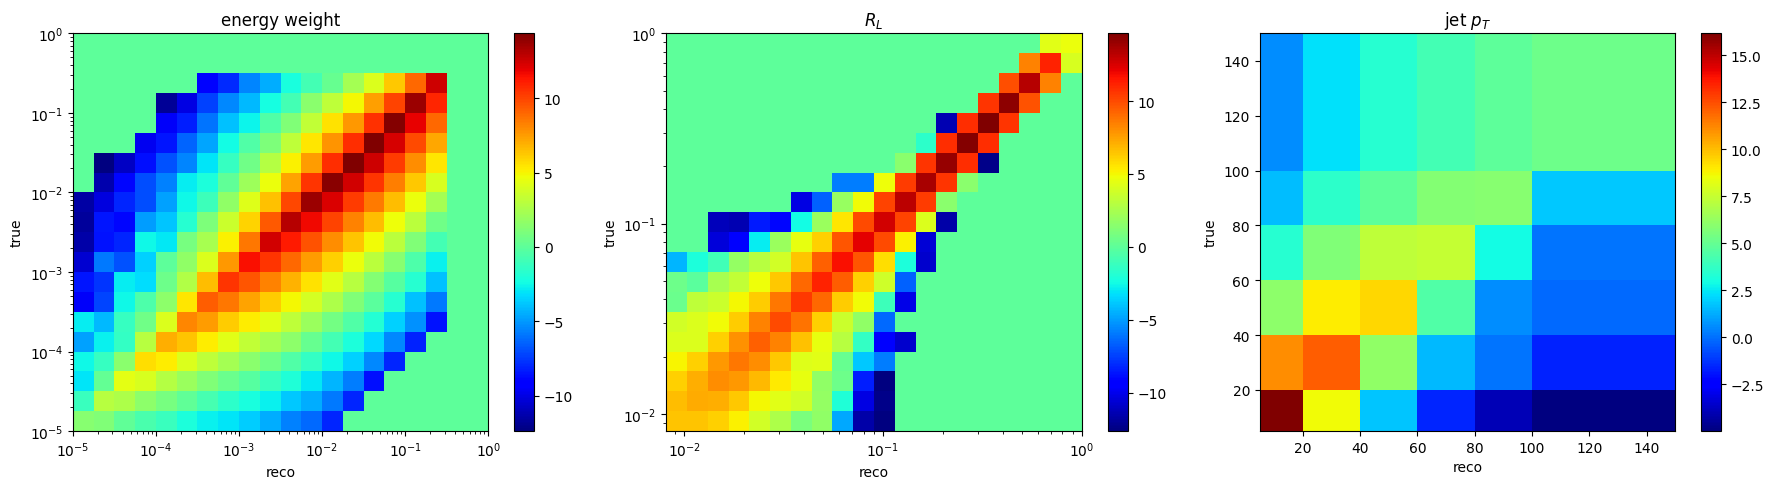

In [5]:
# print response matricies

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i in range(3):
    ax = axes[i]

    # Plot histograms
    #ax.imshow(matrix.values(), origin='lower', extent=[binning[0][0], binning[0][-1], binning[0][0], binning[0][-1]], cmap='viridis')
    h = matricies[i]
    plot = ax.pcolormesh(binning[i], binning[i], np.log(h, out=np.zeros_like(h), where=(h!=0)).T, cmap='jet')
    ax.set_title(labels[i])
    ax.set_xlabel('reco')
    ax.set_ylabel('true')

    if i in [0,1]:
        ax.set_xscale('log')
        ax.set_yscale('log')

    fig.colorbar(plot)


# Show plot
plt.tight_layout()
plt.show()

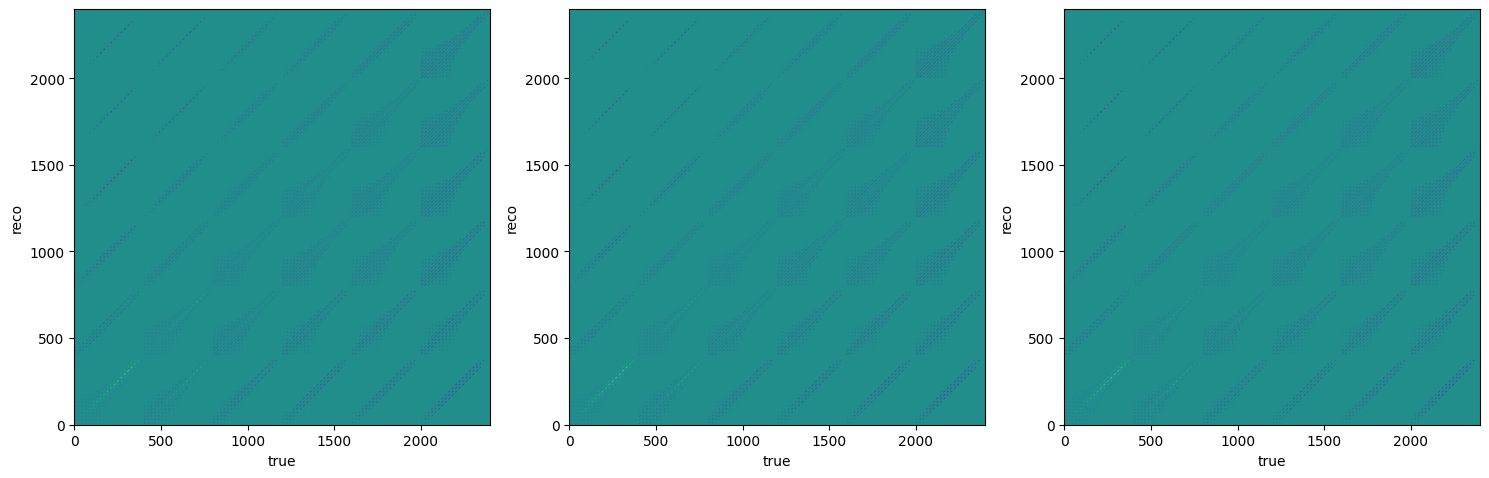

In [6]:
# print response matricies

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    ax = axes[i]

    # Plot histograms
    #ax.imshow(matrix.values(), origin='lower', extent=[binning[0][0], binning[0][-1], binning[0][0], binning[0][-1]], cmap='viridis')
    ax.imshow(np.log(matrix, out=np.zeros_like(matrix), where=(matrix!=0)), origin='lower', cmap='viridis')
    ax.set_xlabel('true')
    ax.set_ylabel('reco')
    #ax.set_xscale('log')
    #ax.set_yscale('log')


# Show plot
plt.tight_layout()
plt.show()

In [7]:
proj = lambda a : np.array([projectionX(a.values()), projectionY(a.values()), projectionZ(a.values())])
proj_err = lambda a : np.array([projectionX(a.errors()), projectionY(a.errors()), projectionZ(a.errors())])

theta0_G = proj(h3_gen)
theta0_S = proj(h3_reco)
theta_unknown_G = proj(h3_true)
theta_unknown_S = proj(h3_raw)

theta_unfolded = [proj(a) for a in h3_unfolded]

theta0_G_err = proj_err(h3_gen)
theta0_S_err = proj_err(h3_reco)
theta_unknown_G_err = proj_err(h3_true)
theta_unknown_S_err = proj_err(h3_raw)

theta_unfolded_err = [proj_err(a) for a in h3_unfolded]

matrixify = lambda A : projectionXY(A.values()).T
matrixify_err = lambda A: projectionXY(A.errors()).T

U_true = matrixify(h3_true)
U_true_err = matrixify_err(h3_true)

U_unfolded = [matrixify(A) for A in h3_unfolded]
U_unfolded_err = [matrixify_err(A) for A in h3_unfolded]

print(theta0_G)


[array([2.68060079e+01, 1.08945285e+02, 4.17827535e+02, 1.44697927e+03,
        4.71391495e+03, 1.45755230e+04, 4.41897165e+04, 1.35973744e+05,
        3.67453137e+05, 8.25248558e+05, 1.54020971e+06, 2.48987813e+06,
        3.42648164e+06, 3.92361749e+06, 3.70288138e+06, 2.78957783e+06,
        1.51244917e+06, 4.55088276e+05, 0.00000000e+00, 0.00000000e+00])
 array([6.68713695e+03, 9.98887110e+03, 1.74413247e+04, 2.72516730e+04,
        4.19881412e+04, 6.83207572e+04, 1.08639324e+05, 1.79128351e+05,
        2.82933624e+05, 4.56502811e+05, 7.19552874e+05, 1.14125982e+06,
        1.78255472e+06, 2.69186622e+06, 3.79780736e+06, 4.61581954e+06,
        3.55085490e+06, 1.50175515e+06, 2.32415948e+05, 1.57023577e+03])
 array([2.07941585e+07, 4.00037318e+05, 3.24213877e+04, 5.60537463e+03,
        1.41676856e+03, 6.99442586e+02])                               ]


/tmp/ipykernel_467689/111962599.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  proj = lambda a : np.array([projectionX(a.values()), projectionY(a.values()), projectionZ(a.values())])
/tmp/ipykernel_467689/111962599.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  proj_err = lambda a : np.array([projectionX(a.errors()), projectionY(a.errors()), projectionZ(a.errors())])


In [8]:
# get total number of jets, manually inputted from 1D jet unfolding

N_jets = 39213
N_jets_err = 0

[array([2.68060079e+01, 1.08945285e+02, 4.17827535e+02, 1.44697927e+03,
        4.71391495e+03, 1.45755230e+04, 4.41897165e+04, 1.35973744e+05,
        3.67453137e+05, 8.25248558e+05, 1.54020971e+06, 2.48987813e+06,
        3.42648164e+06, 3.92361749e+06, 3.70288138e+06, 2.78957783e+06,
        1.51244917e+06, 4.55088276e+05, 0.00000000e+00, 0.00000000e+00])
 array([6.68713695e+03, 9.98887110e+03, 1.74413247e+04, 2.72516730e+04,
        4.19881412e+04, 6.83207572e+04, 1.08639324e+05, 1.79128351e+05,
        2.82933624e+05, 4.56502811e+05, 7.19552874e+05, 1.14125982e+06,
        1.78255472e+06, 2.69186622e+06, 3.79780736e+06, 4.61581954e+06,
        3.55085490e+06, 1.50175515e+06, 2.32415948e+05, 1.57023577e+03])
 array([2.07941585e+07, 4.00037318e+05, 3.24213877e+04, 5.60537463e+03,
        1.41676856e+03, 6.99442586e+02])                               ]
(3,)
[0.00812831 0.01033951 0.01315225 0.01673016 0.02128139 0.02707073
 0.03443499 0.04380261 0.05571857 0.07087613 0.09015711 0.114

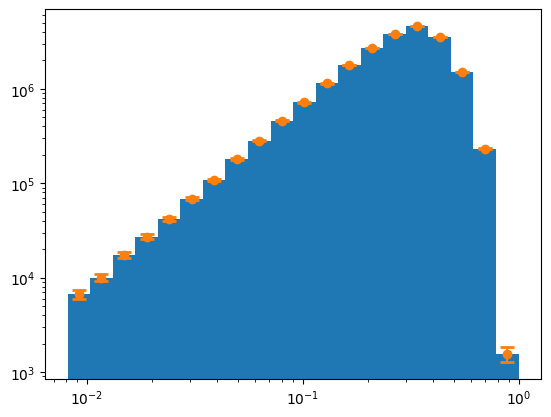

In [9]:
print(theta0_G)
print(theta0_G.shape)
print(binning[1])
print(len(binning[1]))

print(plt.hist(binning[1][:-1], binning[1], weights=theta0_G[1]))
print(len(binning[1][:-1]))
print(len(theta0_G_err[1]))
plt.errorbar(bincenters[1], theta0_G[1], yerr=theta0_G_err[1], capsize=5, capthick=2, fmt='o', linestyle="None")
plt.yscale('log')
plt.xscale('log')
plt.show()

In [10]:
for iteration in range(n_iter):
    print(theta_unfolded[iteration][1])

[8.19091934e+03 1.15222853e+04 1.87125003e+04 2.80844082e+04
 4.24110595e+04 6.86412648e+04 1.08760469e+05 1.79169405e+05
 2.82946764e+05 4.56507646e+05 7.19558710e+05 1.14126697e+06
 1.78256337e+06 2.69187647e+06 3.79781917e+06 4.61583181e+06
 3.55086245e+06 1.50175806e+06 2.32416702e+05 1.56867012e+03]
[8.97985630e+03 1.21077411e+04 1.88792738e+04 2.78204953e+04
 4.20894204e+04 6.84054763e+04 1.08577584e+05 1.79059961e+05
 2.82909552e+05 4.56498887e+05 7.19558077e+05 1.14126704e+06
 1.78256347e+06 2.69187656e+06 3.79781927e+06 4.61583191e+06
 3.55086243e+06 1.50175802e+06 2.32416691e+05 1.56867078e+03]
[9.51168127e+03 1.24017178e+04 1.88505006e+04 2.75010058e+04
 4.18754155e+04 6.83146986e+04 1.08550978e+05 1.79067964e+05
 2.82939023e+05 4.56515815e+05 7.19562778e+05 1.14126765e+06
 1.78256360e+06 2.69187669e+06 3.79781942e+06 4.61583206e+06
 3.55086252e+06 1.50175806e+06 2.32416699e+05 1.56867151e+03]
[9.91257139e+03 1.25649797e+04 1.87759119e+04 2.72263581e+04
 4.17582585e+04 6.829

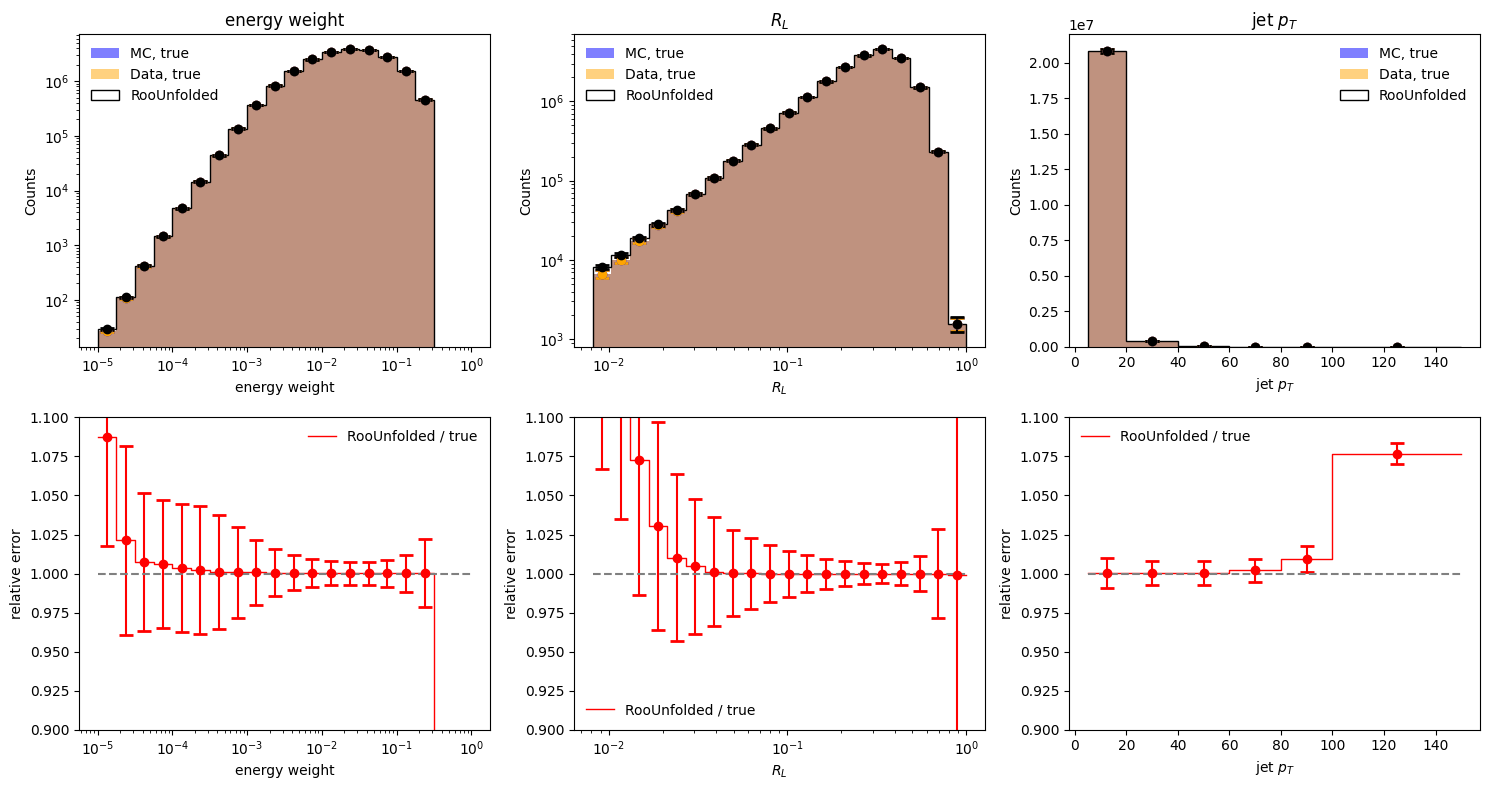

In [11]:
############################## UNFOLDED DISTRIBUTIONS ############################
# individual distros

for iteration in range(1):
    fig, axes = plt.subplots(2, 3, figsize=(15,8))

    # ROW 1: raw distributions
    for i in range(3):
        ax = axes[0, i]

        _,_,_=ax.hist(binning[i][:-1], binning[i], weights=theta0_G[i],color='blue', alpha=0.5, label="MC, true")
        _,_,_=ax.hist(binning[i][:-1], binning[i], weights=theta_unknown_G[i],color='orange',alpha=0.5,label="Data, true")
        _,_,_=ax.hist(binning[i][:-1], binning[i],weights=theta_unfolded[iteration][i],color='black',histtype="step",label="RooUnfolded",lw=1)

        ax.errorbar(bincenters[i], theta0_G[i], yerr=theta0_G_err[i], capsize=5, capthick=2, fmt='o', linestyle="None", color='blue')
        ax.errorbar(bincenters[i], theta_unknown_G[i], yerr=theta_unknown_G_err[i], capsize=5, capthick=2, fmt='o', linestyle="None", color='orange')
        ax.errorbar(bincenters[i], theta_unfolded[iteration][i], yerr=theta_unfolded_err[iteration][i], capsize=5, capthick=2, fmt='o', linestyle="None", color='black')
        
        ax.set_title(labels[i])
        ax.set_xlabel(labels[i])
        ax.set_ylabel("Counts")
        ax.legend(frameon=False)

        if i in [0, 1]:
            ax.set_xscale('log')
            ax.set_yscale('log')
            #ax.set_ylim([0.1, 4E8])
    
    # ROW 2: residual plots
    for i in range(3):
        ax = axes[1, i]
        
        yvals, yerrs = get_ratio_safe(theta_unfolded[iteration][i], theta_unknown_G[i], \
                                      numerr=theta_unfolded_err[iteration][i], denomerr=theta_unknown_G_err[i])
        
        ax.step(binning[i], np.insert(yvals, 0, yvals[0]), where="pre",color='red',label="RooUnfolded / true",lw=1)
        ax.errorbar(bincenters[i], yvals, yerr=yerrs, capsize=5, capthick=2, fmt='o', linestyle="None", color='red')

        ax.hlines(y=1, xmin=binning[i][0], xmax=binning[i][len(binning[i])-1], color='grey', linestyle='--')

        ax.set_xlabel(labels[i])
        ax.set_ylabel("relative error")
        ax.legend(frameon=False)
        
        if i in [0, 1]:
            ax.set_xscale('log')
            ax.set_ylim([0.9, 1.1])
        else:
            ax.set_ylim([0.9, 1.1])

    
    fig.tight_layout()
    # fig.savefig("post_training_" + str(iteration) + ".png")
    # fig.show()
    # plt.close()
plt.show()

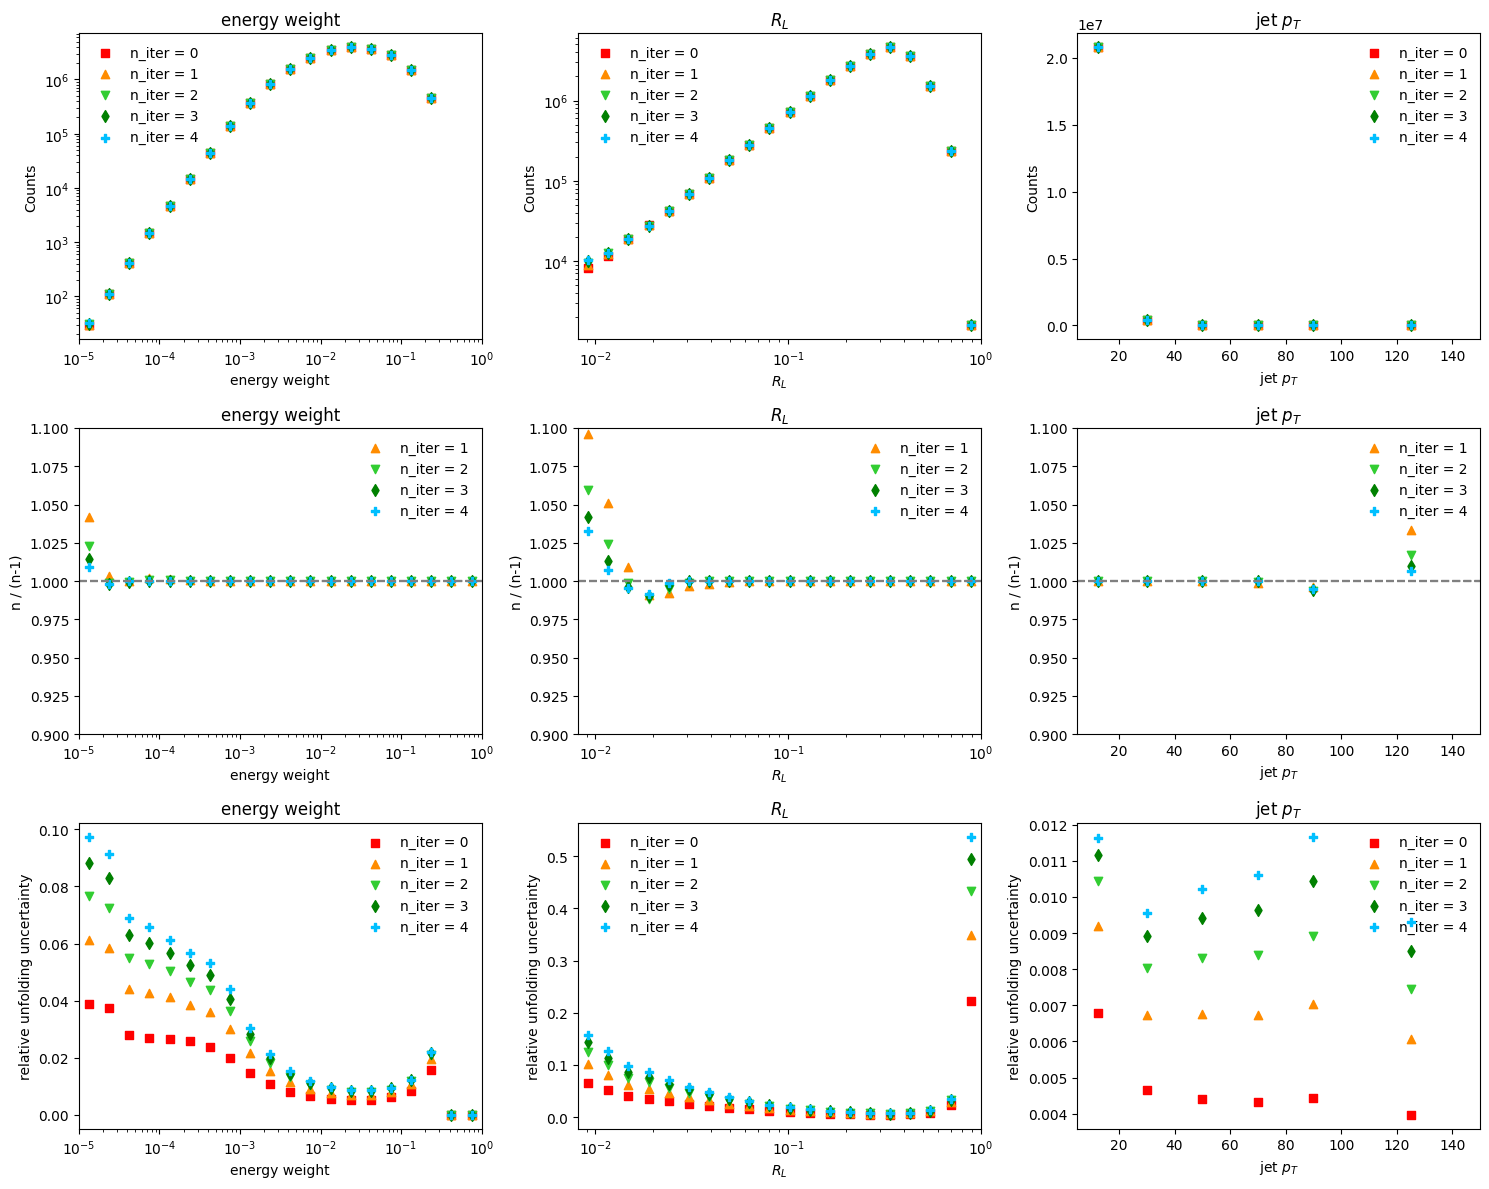

In [12]:
############################## UNFOLDED DISTRIBUTIONS ############################
# individual distros

it = 5

fig, axes = plt.subplots(3, 3, figsize=(15,12))

# ROW 1: raw distributions
for i in range(3):
    ax = axes[0, i]

    for iteration in range(it):
        ax.scatter(bincenters[i], theta_unfolded[iteration][i],color=L_colors[iteration],marker=L_markers[iteration],label="n_iter = {}".format(iteration),lw=1)
        ax.set_ylabel("Counts")

        #ax.errorbar(bincenters[i], theta_unfolded[iteration][i], yerr=theta_unfolded_err[iteration][i], capsize=5, capthick=2, fmt='o', linestyle="None", color=L_colors[iteration])
        
        ax.set_title(labels[i])
        ax.set_xlabel(labels[i])
        
        ax.legend(frameon=False)

        if i in [0, 1]:
            ax.set_xscale('log')
            ax.set_yscale('log')
            #ax.set_ylim([0.1, 4E8])
        ax.set_xlim([binning[i][0], binning[i][len(binning[i])-1]])


# ROW 2: convergence plot (n / n - 1)
for i in range(3):
    ax = axes[1, i]

    for iteration in range(1,it):
    
        yvals = safe_divide(theta_unfolded[iteration][i] , theta_unfolded[iteration-1][i], filler=1)
        ax.scatter(bincenters[i], yvals, color=L_colors[iteration],marker=L_markers[iteration],label="n_iter = {}".format(iteration),lw=1)

        ax.hlines(y=1, xmin=binning[i][0], xmax=binning[i][len(binning[i])-1], color='grey', linestyle='--')

        ax.set_title(labels[i])
        ax.set_xlabel(labels[i])
        ax.set_ylabel("n / (n-1)")
        ax.legend(frameon=False)

        if i in [0, 1]:
            ax.set_xscale('log')
        ax.set_ylim([0.9, 1.1])
        ax.set_xlim([binning[i][0], binning[i][len(binning[i])-1]])


# ROW 3: statistical error %
for i in range(3):
    ax = axes[2, i]

    for iteration in range(it):
        
        yvals = safe_divide(theta_unfolded_err[iteration][i], theta_unfolded[iteration][i])
        ax.scatter(bincenters[i], yvals, color=L_colors[iteration],marker=L_markers[iteration],label="n_iter = {}".format(iteration),lw=1)

        ax.set_title(labels[i])
        ax.set_xlabel(labels[i])
        ax.set_ylabel("relative unfolding uncertainty")
        ax.legend(frameon=False)

        if i in [0, 1]:
            ax.set_xscale('log')
        ax.set_xlim([binning[i][0], binning[i][len(binning[i])-1]])


fig.tight_layout()
plt.show()

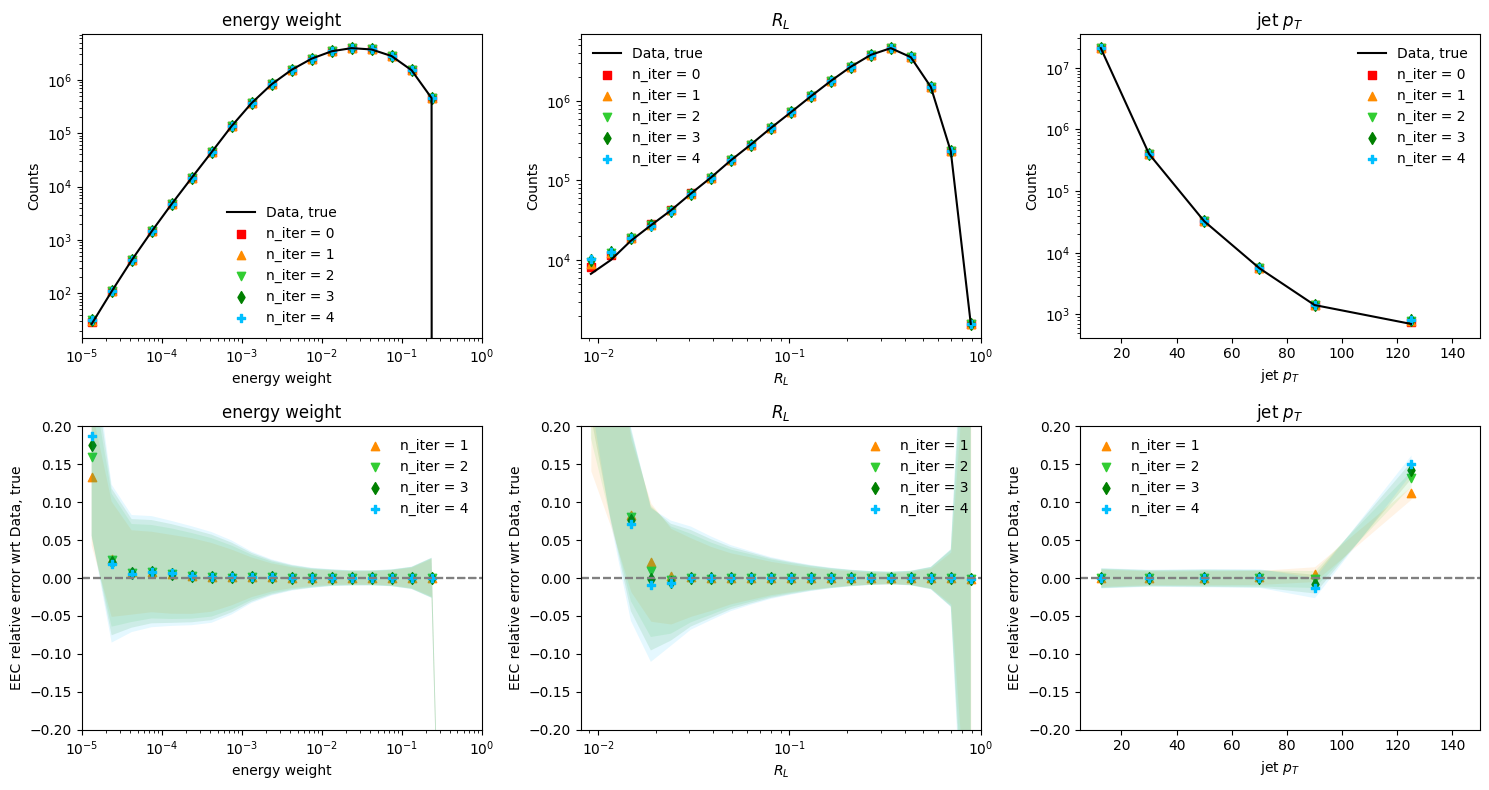

In [13]:
############################## UNFOLDED DISTRIBUTIONS ############################
# individual distros

it = 5

fig, axes = plt.subplots(2, 3, figsize=(15,8))

# ROW 1: raw distributions
for i in range(3):
    ax = axes[0, i]

    if i == 0:
        ax.plot(bincenters[i][:-1], theta_unknown_G[i][:-1], color='black',label="Data, true")
    else:
        ax.plot(bincenters[i], theta_unknown_G[i], color='black',label="Data, true")

    for iteration in range(it):
        ax.scatter(bincenters[i], theta_unfolded[iteration][i],color=L_colors[iteration],marker=L_markers[iteration],label="n_iter = {}".format(iteration),lw=1)
        ax.set_ylabel("Counts")

        #ax.errorbar(bincenters[i], theta_unfolded[iteration][i], yerr=theta_unfolded_err[iteration][i], capsize=5, capthick=2, fmt='o', linestyle="None", color=L_colors[iteration])
        
        ax.set_title(labels[i])
        ax.set_xlabel(labels[i])
        
        ax.legend(frameon=False)

        if i in [0, 1]:
            ax.set_xscale('log')
            #ax.set_ylim([0.1, 4E8])
        ax.set_yscale('log')
        ax.set_xlim([binning[i][0], binning[i][len(binning[i])-1]])


# ROW 2: error wrt Data, true
for i in range(3):
    ax = axes[1, i]

    for iteration in range(1,it):

        yvals, yerrs = get_ratio_safe(theta_unfolded[iteration][i], theta_unknown_G[i], \
                                      numerr=theta_unfolded_err[iteration][i], denomerr=theta_unknown_G_err[i])
        yvals = yvals - 1

        ax.scatter(bincenters[i], yvals, color=L_colors[iteration],marker=L_markers[iteration],label="n_iter = {}".format(iteration),lw=1)

        if i == 0:
            ax.fill_between(bincenters[i][:-1], (yvals-yerrs)[:-1], (yvals+yerrs)[:-1], alpha=0.1, edgecolor=L_colors[iteration], facecolor=L_colors[iteration], linewidth=0)
        else:
            ax.fill_between(bincenters[i], yvals-yerrs, yvals+yerrs, alpha=0.1, edgecolor=L_colors[iteration], facecolor=L_colors[iteration], linewidth=0)

        ax.hlines(y=0, xmin=binning[i][0], xmax=binning[i][len(binning[i])-1], color='grey', linestyle='--')

        ax.set_title(labels[i])
        ax.set_xlabel(labels[i])
        ax.set_ylabel("EEC relative error wrt Data, true")
        ax.legend(frameon=False)

        if i in [0, 1]:
            ax.set_xscale('log')
        ax.set_ylim([-0.2, 0.2])
        ax.set_xlim([binning[i][0], binning[i][len(binning[i])-1]])

fig.tight_layout()
plt.show()


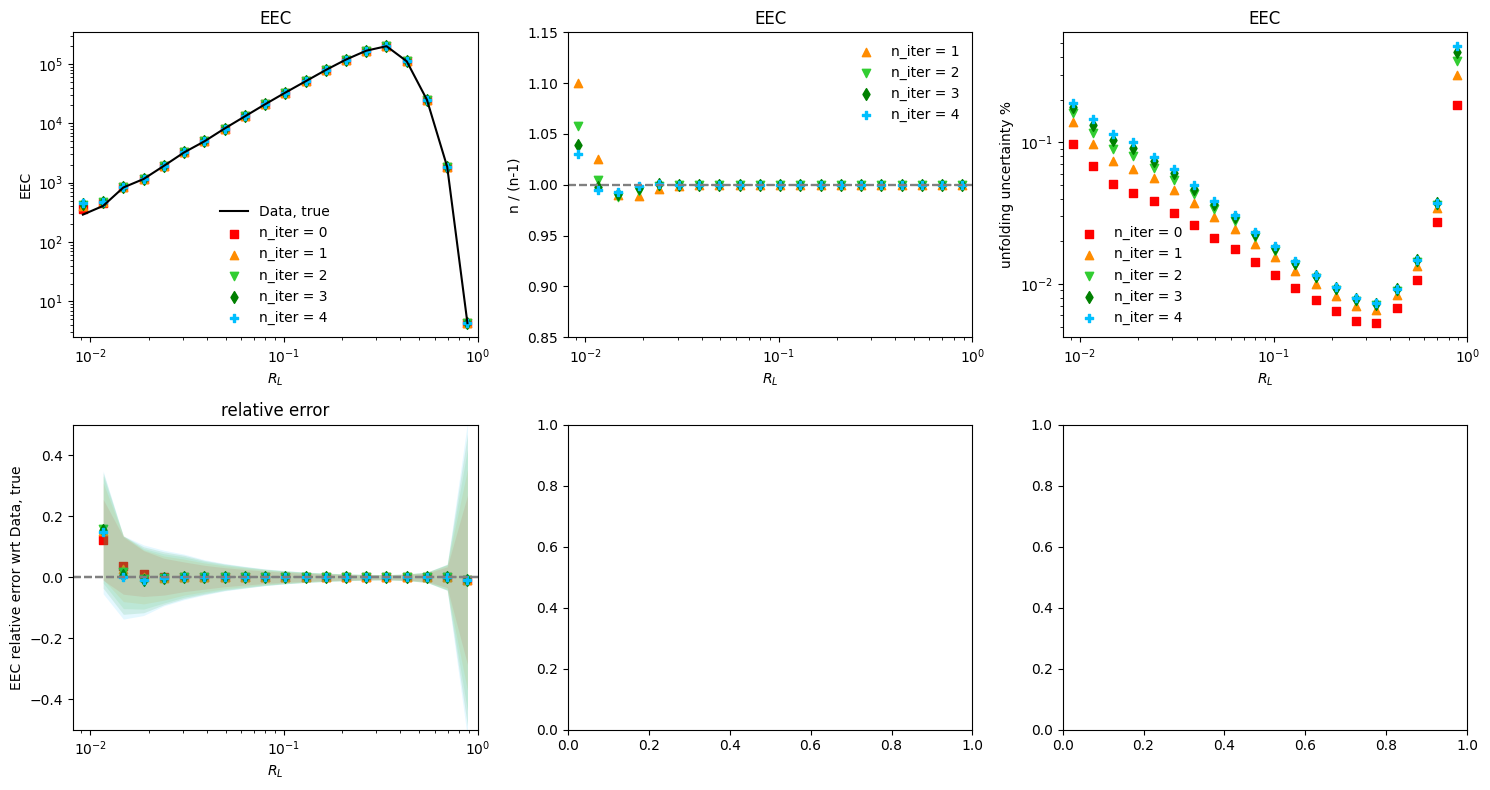

In [14]:
############################## UNFOLDED DISTRIBUTIONS ############################
# EEC distros

it = 5

fig, axes = plt.subplots(2, 3, figsize=(15,8))

# EEC weight calculation:
# w_n = U * b, U is matrixfied RL-energy weight 2D histogram, b is bincenters of energy weights

true_EEC = np.array([np.dot(col, bincenters[0]) for col in U_true])
true_EEC_err = np.array([np.dot(col, bincenters[0]) for col in U_true_err])

unfolded_EEC = np.array([[np.dot(col, bincenters[0]) for col in U_unfolded[iteration]] for iteration in range(len(theta_unfolded))])
unfolded_EEC_err = np.array([[np.dot(col, bincenters[0]) for col in U_unfolded_err[iteration]] for iteration in range(len(theta_unfolded))])

# COL 1: raw EEC distribution WITH relative error over data, true underneath
ax = axes[0, 0]

rl_lims = ax.set_xlim([binning[1][0], binning[1][len(binning[1])-1]])

ax.plot(bincenters[1], true_EEC, color='black',label="Data, true")

for iteration in range(it):

    ax.scatter(bincenters[1], unfolded_EEC[iteration],color=L_colors[iteration],marker=L_markers[iteration],label="n_iter = {}".format(iteration),lw=1)
    ax.set_ylabel("EEC")
    
    ax.set_title("EEC")
    ax.set_xlabel(labels[1])

    ax.legend(frameon=False)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(rl_lims)

# row below with the error

ax = axes[1, 0]

ax.hlines(y=0, xmin=binning[1][0], xmax=binning[1][len(binning[1])-1], color='grey', linestyle='--')

for iteration in range(it):

    yvals, yerrs = get_ratio_safe(unfolded_EEC[iteration], true_EEC, \
                                      numerr=unfolded_EEC_err[iteration], denomerr=true_EEC_err, filler=1)
    yvals = yvals - 1

    ax.scatter(bincenters[1][1:], yvals[1:], color=L_colors[iteration],marker=L_markers[iteration],label="n_iter = {}".format(iteration),lw=1)

    ax.fill_between(bincenters[1][1:], (yvals-yerrs)[1:], (yvals+yerrs)[1:], alpha=0.1, edgecolor=L_colors[iteration], facecolor=L_colors[iteration], linewidth=0)

    ax.hlines(y=0, xmin=binning[1][0], xmax=binning[1][len(binning[1])-1], color='grey', linestyle='--')
    

    ax.set_title("relative error")
    ax.set_xlabel(labels[1])
    ax.set_ylabel("EEC relative error wrt Data, true")

    ax.set_xscale('log')
    ax.set_ylim([-0.5, 0.5])
    ax.set_xlim(rl_lims)


# COL 2: convergence plot (n / n - 1)
ax = axes[0, 1]

for iteration in range(1,it):

    yvals = safe_divide(unfolded_EEC[iteration], unfolded_EEC[iteration-1], filler=1)
    ax.scatter(bincenters[1], yvals, color=L_colors[iteration],marker=L_markers[iteration],label="n_iter = {}".format(iteration),lw=1)

    ax.hlines(y=1, xmin=binning[1][0], xmax=binning[1][len(binning[1])-1], color='grey', linestyle='--')

    ax.set_title("EEC")
    ax.set_xlabel(labels[1])
    ax.set_ylabel("n / (n-1)")
    ax.legend(frameon=False)

    ax.set_xscale('log')
    ax.set_ylim([0.85, 1.15])
    ax.set_xlim(rl_lims)


# COL 3: statistical error %
ax = axes[0, 2]

for iteration in range(it):
    
    yvals = safe_divide(unfolded_EEC_err[iteration], unfolded_EEC[iteration])
    ax.scatter(bincenters[1], yvals, color=L_colors[iteration],marker=L_markers[iteration],label="n_iter = {}".format(iteration),lw=1)

    ax.set_title("EEC")
    ax.set_xlabel(labels[1])
    ax.set_ylabel("unfolding uncertainty %")
    ax.legend(frameon=False)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(rl_lims)


fig.tight_layout()
plt.show()


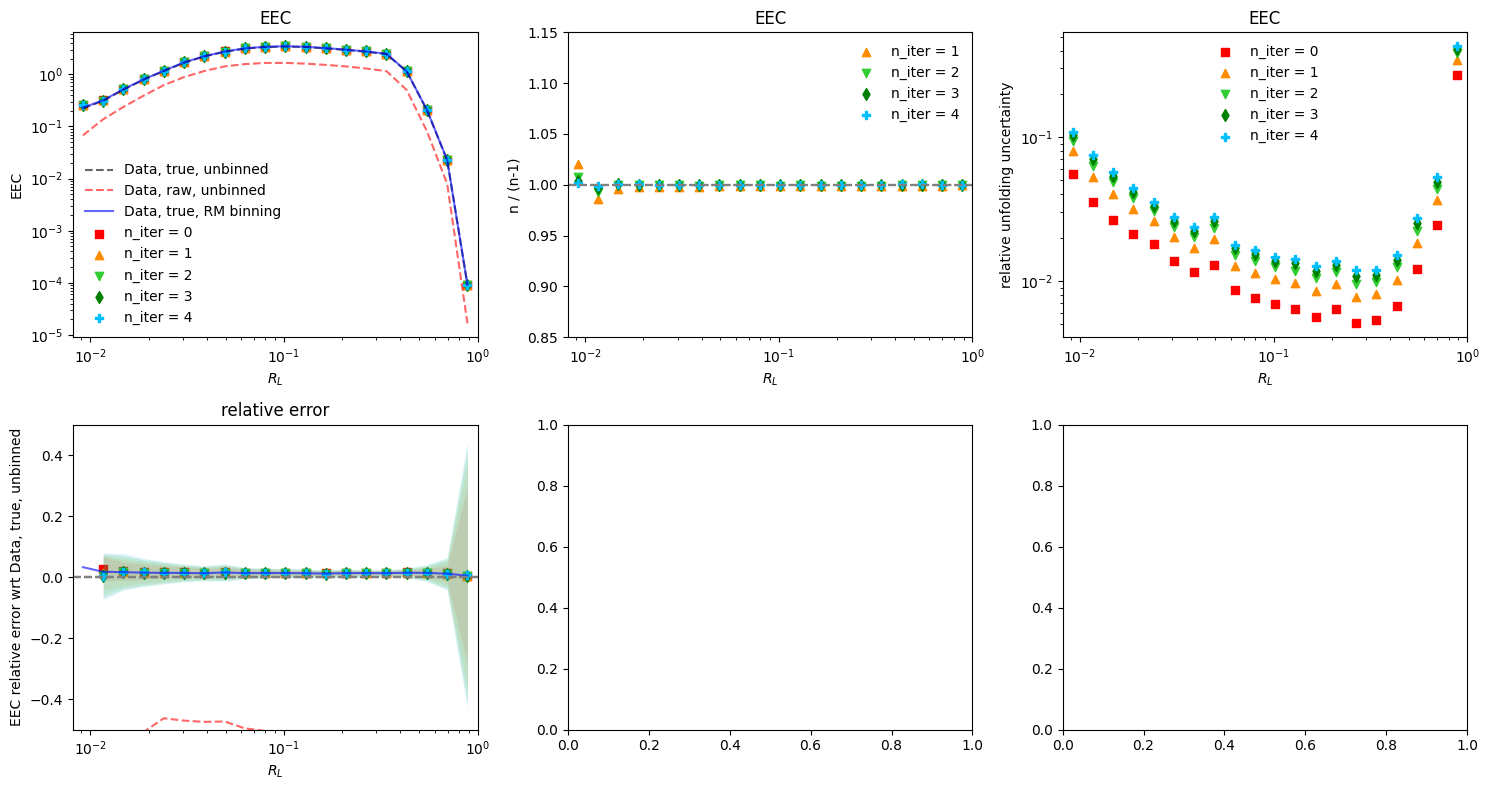

In [18]:
############################## UNFOLDED DISTRIBUTIONS ############################
############################## ( with pT cut applied ) ###########################

# EEC distros

it = 5

fig, axes = plt.subplots(2, 3, figsize=(15,8))

ptcut_bins = [3, 4]
slice_on_pt = lambda h : zslice(h, ptcut_bins[0], ptcut_bins[1]).T

U_true_cut = slice_on_pt(h3_true.values())
U_true_err_cut = slice_on_pt(h3_true.errors())

U_unfolded_cut = [slice_on_pt(A.values()) for A in h3_unfolded]
U_unfolded_err_cut = [slice_on_pt(A.errors()) for A in h3_unfolded]

# EEC weight calculation:
# w_n = U * b, U is matrixfied RL-energy weight 2D histogram, b is bincenters of energy weights

true_EEC = np.array([np.dot(col, bincenters[0]) for col in U_true_cut])
true_EEC_err = np.array([np.dot(col, bincenters[0]) for col in U_true_err_cut])

unfolded_EEC = np.array([[np.dot(col, bincenters[0]) for col in U_unfolded_cut[iteration]] for iteration in range(len(theta_unfolded))])
unfolded_EEC_err = np.array([[np.dot(col, bincenters[0]) for col in U_unfolded_err_cut[iteration]] for iteration in range(len(theta_unfolded))])

# COL 1: raw EEC distribution WITH relative error over data, true underneath
ax = axes[0, 0]

rl_lims = ax.set_xlim([binning[1][0], binning[1][len(binning[1])-1]])

# various comparison EEC plots

# Data, true, unbinned in energy weight (is the actaul truth)
# should be close to RM binning when energy weight granulatrity is ok, also used to check definition of energy weight log bin center
# TODO reimplement after RMs regened correctly
true_eec_unbinned = yslice(h2_true_eec.values(), ptcut_bins[0], ptcut_bins[1])
true_eec_unbinned_err = yslice(h2_true_eec.errors(), ptcut_bins[0], ptcut_bins[1])
ax.plot(bincenters[1], true_eec_unbinned, color='black', alpha=0.6, linestyle='dashed', label="Data, true, unbinned")

# Data, raw, unbinned in energy weight
raw_eec_unbinned = yslice(h2_raw_eec.values(), ptcut_bins[0], ptcut_bins[1])
raw_eec_unbinned_err = yslice(h2_raw_eec.errors(), ptcut_bins[0], ptcut_bins[1])
ax.plot(bincenters[1], raw_eec_unbinned, color='red', alpha=0.6, linestyle='dashed', label="Data, raw, unbinned")

# Data, true, RM binning with binnings from the response matrix (i.e. calculated with some binned energy weight)
ax.plot(bincenters[1], true_EEC, color='blue', alpha=0.6, label="Data, true, RM binning")

for iteration in range(it):

    ax.scatter(bincenters[1], unfolded_EEC[iteration],color=L_colors[iteration],marker=L_markers[iteration],label="n_iter = {}".format(iteration),lw=1)
    ax.set_ylabel("EEC")
    
    ax.set_title("EEC")
    ax.set_xlabel(labels[1])

    ax.legend(frameon=False)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(rl_lims)

# row below with the error

ax = axes[1, 0]

ax.hlines(y=0, xmin=binning[1][0], xmax=binning[1][len(binning[1])-1], color='grey', linestyle='--')

yvals, yerrs = get_ratio_safe(true_EEC, true_eec_unbinned, \
                                      numerr=true_EEC_err, denomerr=true_eec_unbinned_err, filler=1)
yvals = yvals - 1
ax.plot(bincenters[1], yvals, color='blue', alpha=0.6, label="Data, true, RM binning")

yvals, yerrs = get_ratio_safe(raw_eec_unbinned, true_eec_unbinned, \
                                      numerr=raw_eec_unbinned, denomerr=true_eec_unbinned_err, filler=1)
yvals = yvals - 1
ax.plot(bincenters[1], yvals, color='red', alpha=0.6, linestyle='dashed', label="Data, raw, unbinned")

for iteration in range(it):

    yvals, yerrs = get_ratio_safe(unfolded_EEC[iteration], true_eec_unbinned, \
                                      numerr=unfolded_EEC_err[iteration], denomerr=true_eec_unbinned_err, filler=1)
    yvals = yvals - 1

    ax.scatter(bincenters[1][1:], yvals[1:], color=L_colors[iteration],marker=L_markers[iteration],label="n_iter = {}".format(iteration),lw=1)

    ax.fill_between(bincenters[1][1:], (yvals-yerrs)[1:], (yvals+yerrs)[1:], alpha=0.1, edgecolor=L_colors[iteration], facecolor=L_colors[iteration], linewidth=0)

    ax.hlines(y=0, xmin=binning[1][0], xmax=binning[1][len(binning[1])-1], color='grey', linestyle='--')
    

    ax.set_title("relative error")
    ax.set_xlabel(labels[1])
    ax.set_ylabel("EEC relative error wrt Data, true, unbinned")

    ax.set_xscale('log')
    ax.set_ylim([-0.5, 0.5])
    ax.set_xlim(rl_lims)


# COL 2: convergence plot (n / n - 1)
ax = axes[0, 1]

for iteration in range(1,it):

    yvals = safe_divide(unfolded_EEC[iteration], unfolded_EEC[iteration-1], filler=1)
    ax.scatter(bincenters[1], yvals, color=L_colors[iteration],marker=L_markers[iteration],label="n_iter = {}".format(iteration),lw=1)

    ax.hlines(y=1, xmin=binning[1][0], xmax=binning[1][len(binning[1])-1], color='grey', linestyle='--')

    ax.set_title("EEC")
    ax.set_xlabel(labels[1])
    ax.set_ylabel("n / (n-1)")
    ax.legend(frameon=False)

    ax.set_xscale('log')
    ax.set_ylim([0.85, 1.15])
    ax.set_xlim(rl_lims)


# COL 3: statistical error %
ax = axes[0, 2]

for iteration in range(it):
    
    yvals = safe_divide(unfolded_EEC_err[iteration], unfolded_EEC[iteration])
    ax.scatter(bincenters[1], yvals, color=L_colors[iteration],marker=L_markers[iteration],label="n_iter = {}".format(iteration),lw=1)

    ax.set_title("EEC")
    ax.set_xlabel(labels[1])
    ax.set_ylabel("relative unfolding uncertainty")
    ax.legend(frameon=False)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(rl_lims)


fig.tight_layout()
plt.show()
